# Talking Data - Kaggle Challenge [Halfway through EDA so far]

Objective: Predict age & gender of mobile users based on their app usage, geolocation, and mobile device properties.

Notebook is arranged as follows:
1. Load and pre-process data;
2. Exploratory data analysis;
3. Model construction;
4. Prediction & Conclusion.

Note: Actual work went back-and-forth amongst multiple steps, order in notebook was chosen so it would be more digestible.

## 1. Load and Pre-process data

In [41]:
import pandas as pd
import datetime as datetime
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import os
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
train = pd.read_csv("gender_age_train.csv")
test = pd.read_csv("gender_age_test.csv") 
events = pd.read_csv("events.csv", usecols=['event_id','device_id']) # not using timestamp, latitude, longitude bc negligible correlation
label_categories = pd.read_csv("label_categories.csv") 
phone = pd.read_csv("phone_brand_device_model.csv")
phone = phone.drop_duplicates() # Drop the 523 rows that were duplicated in this df
app_events = pd.read_csv("app_events.csv", dtype={'is_active':bool}) # mega heavy, avoid parsing this more than once
app_labels = pd.read_csv("app_labels.csv")

In [14]:
train.head()

,event_id,device_id
0,1,29182687948017175
1,2,-6401643145415154744
2,3,-4833982096941402721
3,4,-6815121365017318426
4,5,-5373797595892518570


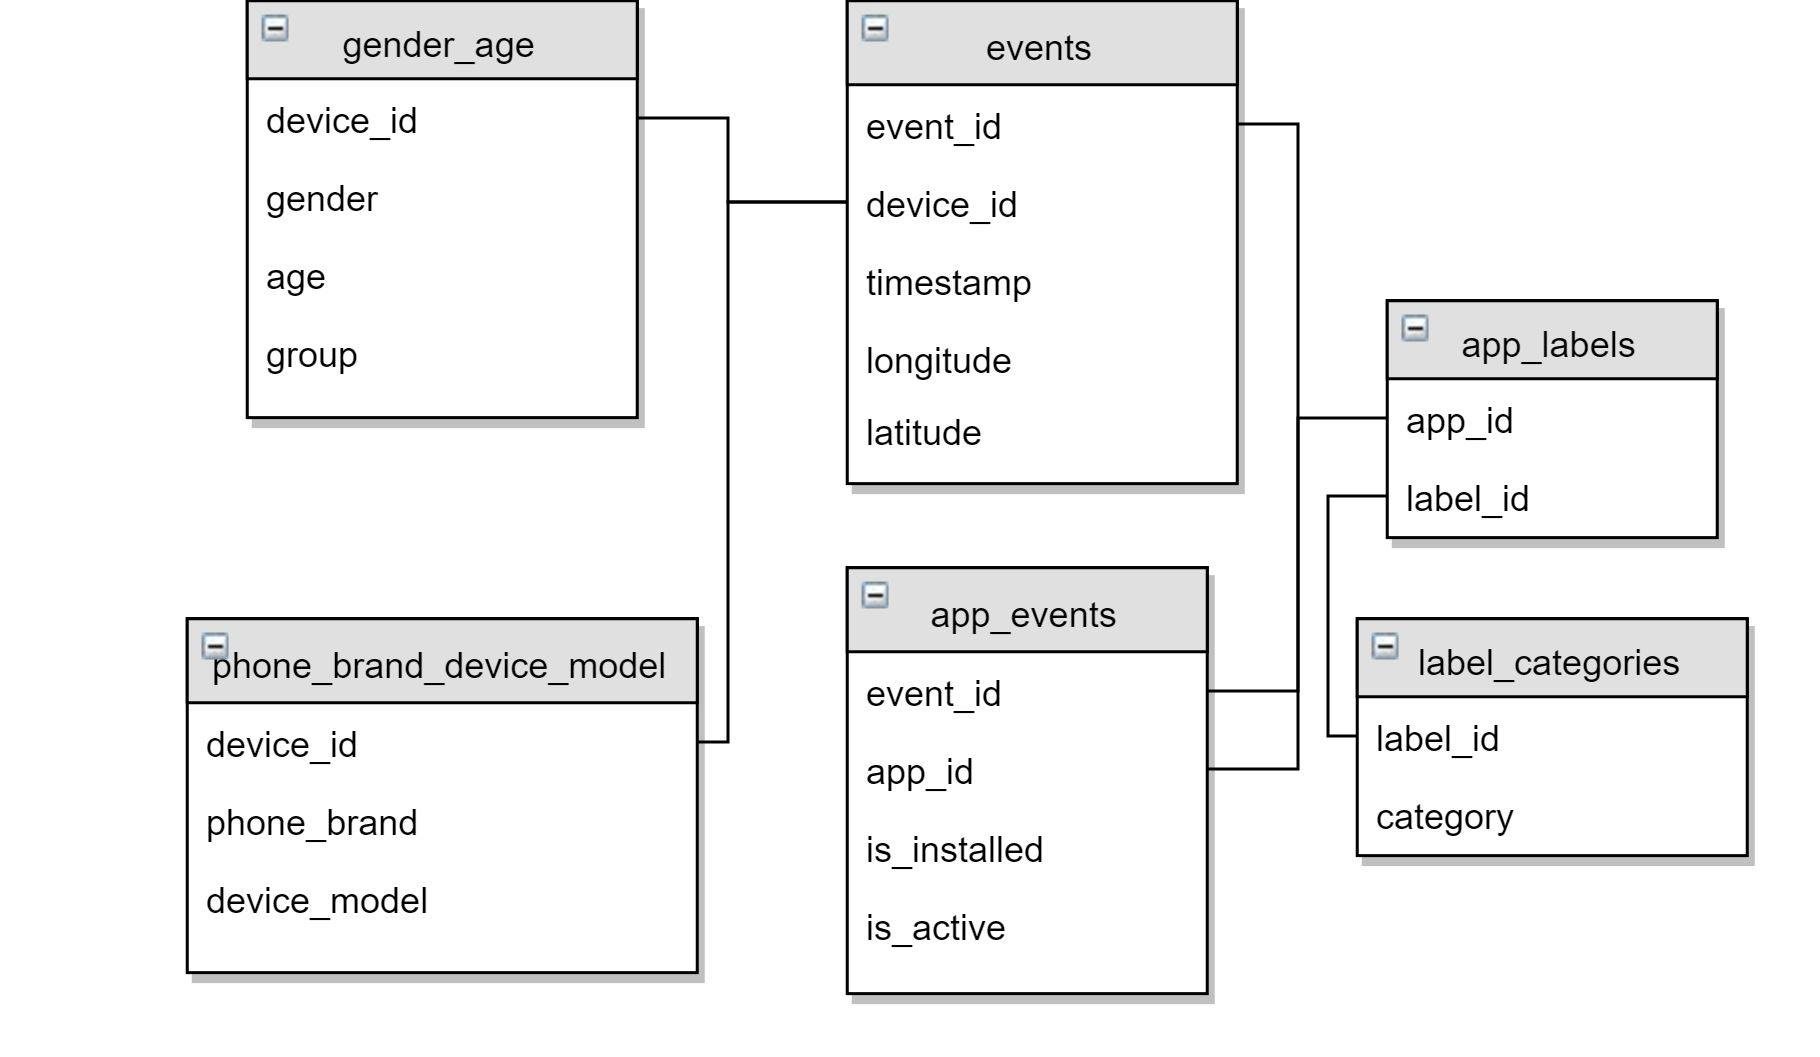

In [5]:
from IPython.display import Image
path = os.getcwd() + "\RelationalDatabasesFlow.jpg"
Image(filename= path, width=500, height=500)

# Flow of relational databases involved in this dataset

One-hot enconding brands, models, installed and labeled apps to facilitate feature engineering for the regression model.
Use sparse matrices so computations are less of a nightmare.

In [3]:
# Encode the brand and device into numeric values rather than strings to ease regression

brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
modelencoder = LabelEncoder().fit(phone.device_model)
phone['model'] = modelencoder.transform(phone['device_model'])

In [4]:
# Merge the train and test dfs with the encoded phone df so it can be more easily accessible

train2 = pd.merge(train,phone,how='left', on='device_id')
test2 = pd.merge(test,phone,how='left',on='device_id')
train2.head()

,device_id,gender,age,group,phone_brand,device_model,brand,model
0,-8076087639492063270,M,35,M32-38,小米,MI 2,51,749
1,-2897161552818060146,M,35,M32-38,小米,MI 2,51,749
2,-8260683887967679142,M,35,M32-38,小米,MI 2,51,749
3,-4938849341048082022,M,30,M29-31,小米,红米note,51,1524
4,245133531816851882,M,30,M29-31,小米,MI 3,51,753


In [5]:
# Separating the variables to input in csr_matrix function so it can be readable.

a = np.ones(train2.shape[0])
b = np.arange(train2.shape[0])
c = train2.brand
d = train2.shape[0]
e = phone.phone_brand.nunique()

f = np.ones(test2.shape[0])
g = np.arange(test2.shape[0])
h = test2.brand
i = test2.shape[0]
j = e

k = a
l = b
m = train2.model
n = d
o = phone.device_model.nunique()

p = f
q = g
r = test2.model
s = i
t = o

# Create the sparse matrices for brand and model for both train and test dfs

train_brand = csr_matrix((a, (b, c)), shape=(d,e))
test_brand = csr_matrix((f,(g, h)), shape=(i,j))
train_model = csr_matrix((k, (l, m)), shape=(n,o))
test_model = csr_matrix((p, (q, r)), shape=(s,t))

# Under impression that indices are not matching, aka, 1st row of csr matrices are empty when it shouldnt

In [6]:
appencoder = LabelEncoder().fit(app_events.app_id)
app_events['app'] = appencoder.transform(app_events.app_id)

app_events.head()

,event_id,app_id,is_installed,is_active,app
0,2,5927333115845830913,1,True,15408
1,2,-5720078949152207372,1,False,3384
2,2,-1633887856876571208,1,False,7620
3,2,-653184325010919369,1,True,8902
4,2,8693964245073640147,1,True,18686


In [7]:
# device_apps df contains all apps that each device has installed and activated. 

train3 = train2.set_index('device_id')            # Setting index to prep for merging in next lines
train3['trainrow'] = np.arange(train3.shape[0])
test3 = test2.set_index('device_id')
test3['testrow'] = np.arange(test3.shape[0])


device_apps = pd.merge(app_events,events, how='left', left_on='event_id',right_on='event_id')
device_apps = device_apps.groupby(['device_id','app'])['app'].agg(['size']).reset_index()
device_apps = pd.merge(device_apps, train3[['trainrow']], how='left', left_on='device_id', right_index=True)
device_apps = pd.merge(device_apps, test3[['testrow']],how='left',left_on='device_id',right_index=True)
device_apps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [8]:
total_apps = len(appencoder.classes_)

traindata = device_apps.dropna(subset=['trainrow'])
testdata = device_apps.dropna(subset=['testrow'])

# Create sparse matrix for the apps installed and activated in devices

train_app = csr_matrix((np.ones(traindata.shape[0]), (traindata.trainrow,traindata.app)), shape=(train2.shape[0],total_apps))
test_app = csr_matrix((np.ones(testdata.shape[0]), (testdata.testrow,testdata.app)), shape=(test2.shape[0],total_apps))

In [9]:
# Cleaning and encoding the app labels

app_labels2 = app_labels.loc[app_labels.app_id.isin(app_events.app_id.unique())]
app_labels2['app'] = appencoder.transform(app_labels2.app_id)
label_encoder = LabelEncoder().fit(app_labels2.label_id)
app_labels2['label'] = label_encoder.transform(app_labels2.label_id)

app_labels2.head()

# Giving SettingWithCopyWarning: a value is trying to be set on a copy of a slice from a Dataframe. Investigate this.

C:\Users\jonasca\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jonasca\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,app_id,label_id,app,label
0,7324884708820027918,251,17355,207
1,-4494216993218550286,251,4618,207
2,6058196446775239644,406,15548,247
3,6058196446775239644,407,15548,248
4,8694625920731541625,406,18689,247


In [10]:
# Same procedure as in device_apps.

device_labels = pd.merge(device_apps[['device_id','app']],app_labels2[['app','label']], how='left',left_on='app',right_on='app')
device_labels = device_labels.groupby(['device_id','label'])['app'].agg(['size']).reset_index()
device_labels = pd.merge(device_labels,train3[['trainrow']], how='left',left_on='device_id',right_index=True)
device_labels = pd.merge(device_labels,test3[['testrow']],how='left',left_on='device_id',right_index=True)
device_labels.head()

,device_id,label,size,trainrow,testrow
0,-9222956879900151005,117,1,21594.0,NaN
1,-9222956879900151005,120,1,21594.0,NaN
2,-9222956879900151005,126,1,21594.0,NaN
3,-9222956879900151005,138,2,21594.0,NaN
4,-9222956879900151005,147,2,21594.0,NaN


In [11]:
# Same process as in above for sparse matrices for apps

number_labels = len(label_encoder.classes_)

traindata = device_labels.dropna(subset=['trainrow'])
testdata = device_labels.dropna(subset=['testrow'])

train_label = csr_matrix((np.ones(traindata.shape[0]),(traindata.trainrow, traindata.label)),shape=(train2.shape[0],number_labels))
test_label = csr_matrix((np.ones(testdata.shape[0]), (testdata.testrow, testdata.label)), shape=(test2.shape[0],number_labels))

In [38]:
# Now finally, to concatenate all these features/sparse matrices together!

Xtrain = hstack((train_brand, train_model, train_app, train_label), format='csr')
Xtest =  hstack((test_brand, test_model, test_app, test_label), format='csr')

#### Aaaand, we're finally done with the data cleaning and manipulating! Now to the EDA results.

## 2. Exploratory Data Analysis

Mostly comprised of the experimentations that resulted in some kind of interesting feature on the dataset.

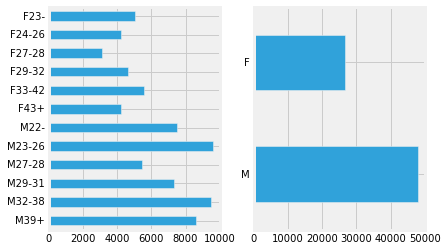

In [9]:
fig, axs = plt.subplots(1,2)
train.group.value_counts().sort_index(ascending=False).plot(ax=axs[0], kind='barh')
train.gender.value_counts().sort_index(ascending=False).plot(ax=axs[1], kind='barh')

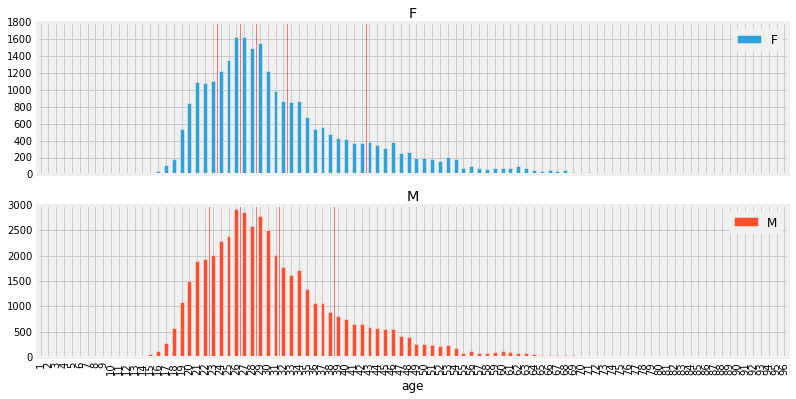

In [10]:
c = train.groupby(['age','gender']).size().unstack().reindex(index=np.arange(train.age.min(), train.age.max()+1)).fillna(0)
ax1,ax2 = c.plot(kind='bar',figsize=(12,6),subplots=True)
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

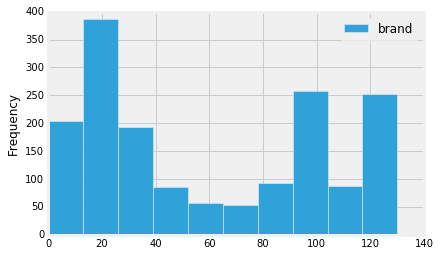

In [11]:
phone.brand.nunique()

phone.plot(kind='hist')

Train has way more males than females

In [114]:
# label_categories.head(10)

train['newgender'] = train['gender']
train['gender'] = train['newgender'].map({'M': 1, 'F': 0}) # keeping the M & F column in dataset just in case

train.head(10)

,device_id,gender,age,group,newgender
0,-8076087639492063270,1,35,M32-38,M
1,-2897161552818060146,1,35,M32-38,M
2,-8260683887967679142,1,35,M32-38,M
3,-4938849341048082022,1,30,M29-31,M
4,245133531816851882,1,30,M29-31,M
5,-1297074871525174196,0,24,F24-26,F
6,236877999787307864,1,36,M32-38,M
7,-8098239495777311881,1,38,M32-38,M
8,176515041953473526,1,33,M32-38,M
9,1596610250680140042,0,36,F33-42,F


## 3. Model Construction

In [55]:
target_encoder = LabelEncoder().fit(train2.group)
y = target_encoder.transform(train2.group)
number_classes = len(target_encoder.classes_)

# Score function to quantify model performance, using StratifiedKFold

def score(clf, random_state = 0):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],number_classes))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])))
    print('')
    return log_loss(y, pred)

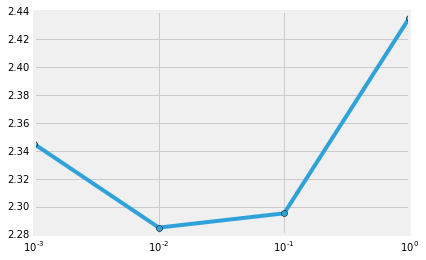

In [34]:
# Use a stronger regularization constant than the default C=1.0 to account for the columns that are barely used,
# like those with rare brands or apps.

Cs = np.logspace(-3,0,4) 
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C))) # This is where the LogisticRegression alg shows up - but what does it do?
plt.semilogx(Cs, res,'-o');

# Optimal C is around 0.01 according to graph below!

In [56]:
score(LogisticRegression(C=0.01))

2.2849301793811412

## 4. Prediction & Conclusion

In [40]:
clf = LogisticRegression(C=0.01)
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = test2.index, columns=target_encoder.classes_)
pred.head()

(112076, 12)

#### Model gave a Log Loss prediction of approximately 2.3, which is considerably good when taking into consideration that barely any of the devices have any data on apps, and thus approximately 90% of the prediction was based solely on the brand device and model.